# Solar Modelling

- Location: Singapore (1.3521, 103.8198)
- Time period: 1 Jan 2022 to 1 Jan 2027

Optimal angle algorithm (time_step = 1 minute)
1. Obtain general information (location, time)
2. Gather solar geometric data
3. List candidate angles with fixed increment
4. For each candidate angle, calculate irradiance and insolation generated
4. Get maximum insolation and output candidate angle

Reference: [On the Optimal Tilt Angle and Orientation of an On-Site Solar Photovoltaic Energy Generation System for Sabah’s Rural Electrification](https://www.mdpi.com/2071-1050/13/10/5730)

In [1]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm

In [2]:
class Experiment:
    def __init__(
            self, start, lat=1.3521, lon=103.8198, tz="Asia/Kuala_Lumpur", 
            freqs=[1440, 240, 120, 60, 30, 1], tracking_modes=["post", None]):
        self._tz = tz
        self._days = 1
        self._start = start
        self._end = start + datetime.timedelta(self._days)
        self._location = pvlib.location.Location(lat, lon, tz)
        self._solar_data = self._get_solardata()
        self._sunrise, self._sunset = self._get_solarday()
        self._build_cases(freqs, tracking_modes)
    
    def _get_solardata(self):
        times = pd.date_range(self._start, self._end, freq="1min", tz=self._tz, closed="left")
        solar_position = self._location.get_solarposition(times)
        clearsky = self._location.get_clearsky(times, solar_position=solar_position)
        solar_position = solar_position.merge(clearsky, left_index=True, right_index=True)
        columns = ['elevation', 'zenith', 'azimuth', 'ghi', 'dni', 'dhi']
        solar_position = solar_position.loc[:, columns].rename(columns=
            {'zenith': 'solar_zenith', 'azimuth': 'solar_azimuth'})
        solar_position = solar_position.reset_index(drop=True)
        return solar_position

    def _gather_irradiance(self, solar_data, surface_tilt=None, surface_azimuth=None):
        irrad_records = []
        for _, row in solar_data.iterrows():
            if row['elevation'] > 0:
                irrad = dict(pvlib.irradiance.get_total_irradiance(
                    surface_tilt=surface_tilt if surface_tilt != None else row['solar_zenith'],
                    surface_azimuth=surface_azimuth if surface_azimuth != None else row['solar_azimuth'],
                    solar_zenith=row['solar_zenith'],
                    solar_azimuth=row['solar_azimuth'],
                    dni=row['dni'],
                    ghi=row['ghi'],
                    dhi=row['dhi']))
                irrad = {
                    'total': irrad['poa_global'],
                    'direct': irrad['poa_direct'],
                    'diffuse': irrad['poa_diffuse']}
            else:
                irrad = {
                    'total': 0,
                    'direct': 0,
                    'diffuse': 0}
            irrad_records.append(irrad)    
        return irrad_records

    def _get_optimal_angle(self, solar_data, mode="tilt"):
        upper_limit = 91 if mode == "tilt" else 361
        increment = 5 if mode == "tilt" else 15
        angles = np.arange(0, upper_limit, increment)
        optimal_angle, optimal_insolation = 0, 0
        for angle in angles:
            irrad_array = []
            for _, row in solar_data.iterrows():
                irrad = dict(pvlib.irradiance.get_total_irradiance(
                    surface_tilt=angle if mode == "tilt" else row['solar_zenith'],
                    surface_azimuth=angle if mode == "orient" else row['solar_azimuth'],
                    solar_zenith=row['solar_zenith'],
                    solar_azimuth=row['solar_azimuth'],
                    dni=row['dni'],
                    ghi=row['ghi'],
                    dhi=row['dhi']))['poa_global']
                irrad_array.append(irrad)
            if len(irrad_array) == 1:
                H = irrad_array[0]
            else:
                H = np.trapz(irrad_array)   
           
            if H > optimal_insolation:
                optimal_insolation = H
                optimal_angle = angle
        return optimal_angle

    def _get_solarday(self):
        solar_periods = self._solar_data.query("elevation > 0")
        return solar_periods.index[0], solar_periods.index[-1]

    def _step_tracking(self, freq, tracking_mode="post"):   
        if freq == 1:
            irrad = self._gather_irradiance(self._solar_data)
        else:
            n_rows = self._solar_data.shape[0]
            irrad = []
            # Loop through time periods
            for i in np.arange(0, n_rows+1, freq):
                # Slice solar data for time period
                sub_data = self._solar_data.iloc[i:i+freq, :]
                if sub_data.shape[0]:                
                    if tracking_mode == "post":
                        surface_tilt = self._get_optimal_angle(sub_data, mode="tilt")
                        surface_azimuth = self._get_optimal_angle(sub_data, mode="orient")
                    elif tracking_mode == None:
                        current_row = self._solar_data.iloc[i:i+1, :]
                        surface_tilt = self._get_optimal_angle(current_row, mode="tilt")
                        surface_azimuth = self._get_optimal_angle(current_row, mode="orient")

                # Loop per minute within time period
                sub_irrad = self._gather_irradiance(sub_data, surface_tilt, surface_azimuth)
                irrad.extend(sub_irrad)

        return pd.DataFrame(irrad)

    def _build_cases(self, freqs, tracking_modes):
        case_0 = pd.DataFrame(self._gather_irradiance(
            self._solar_data, surface_tilt=0, surface_azimuth=0))

        self._cases = [case_0]

        for freq in freqs:
            if freq != 1:
                for tracking_mode in tracking_modes:
                    case = self._step_tracking(freq, tracking_mode)
                    self._cases.append(case)
            else:
                case = self._step_tracking(freq, tracking_mode=None)
                self._cases.append(case)

    def plot_irradiance(self):
        fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
        for i, col in enumerate(['total', 'direct', 'diffuse']):
            case_dict = {}
            for j, case in enumerate(self._cases):
                case_dict[f"Case {j+1}"] = case[col]

            pd.DataFrame.from_dict(case_dict).plot(ax=ax[i], title=col, xlabel="time (m)", ylabel="irradiance (W/m^2)")

        plt.tight_layout()
        plt.show()

    def get_insolation(self):
        return [np.trapz(case['total']) for case in self._cases]

    def plot_insolation(self, insolations):     
        fig = plt.figure(figsize=(10,6))
        for i in range(len(self._cases)):
            plt.barh(i+1, insolations[i])

        plt.xlabel("insolation (J/m^2)")
        plt.ylabel("cases")
        plt.show()

## Cases

1. Horizontal (surface tilt = 0, surface_azimuth = 0)
2. Daily tracking (Every 24 hours)
3. Daily tracking (Every 24 hours without prediction)
4. Quad-hourly tracking (Every 4 hours)
5. Quad-hourly tracking (Every 4 hours without prediction)
6. Bi-hourly tracking (Every 2 hours)
7. Bi-hourly tracking (Every 2 hours without prediction)
8. Hourly tracking (Every hour)
9. Hourly tracking (Every hour without prediction)
10. Half-hourly tracking (Every 30 minutes)
11. Half-hourly tracking (Every 30 minutes without prediction)
12. Minutely tracking (Every minute)

### Irradiance vs Time

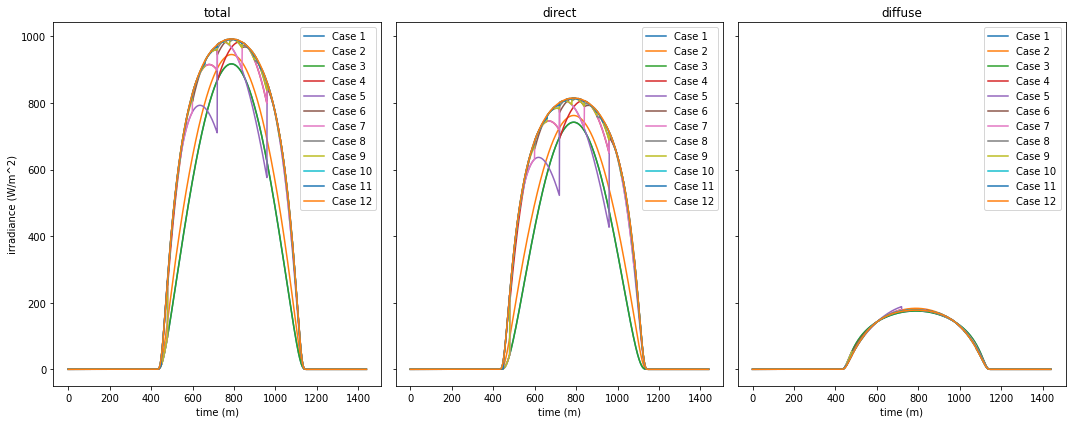

In [3]:
start_date = datetime.datetime(2022, 1, 1, 0, 0, 0)
end_date = datetime.datetime(2027, 1, 1, 0, 0, 0)
date_range = pd.date_range(start_date, end_date, tz="Asia/Kuala_Lumpur", freq="1M")

ex = Experiment(start_date)
ex.plot_irradiance()

### Average Monthly Insolation

  0%|          | 0/60 [00:00<?, ?it/s]

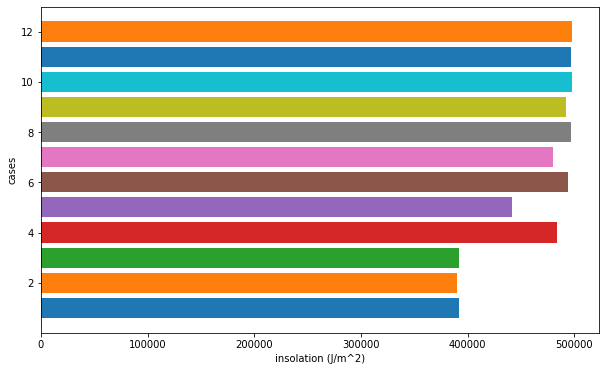

In [4]:
insolations = []
for start in tqdm(date_range):
    ex = Experiment(start)
    insolation = ex.get_insolation()
    insolations.append(insolation)

insolations = np.mean(insolations, axis=0)
ex.plot_insolation(insolations)

## Findings

All monthly insolation values were averaged across 5 years from 2022 to 2027 to decouple the effect of time.

Tracking frequency does not affect diffuse irradiance.

Post-tracking refers to pre-calculating the solar geometric information to obtain the optimal angles between steps using the algorithm mentioned above. 

Post-tracking improves insolation as tracking frequency increases. (See Cases 4 and 5)

Half-hourly tracking without post-tracking generates similar results to post-tracking. (See Cases 10 and 11)